In [1]:
from configs import CFG1, TextBoxCFG, ImageCFG, Point
from generators import generate_data
from generation_utils import get_tiled_option_cfgs
from utils import split_sentence

In [2]:
import pandas as pd

messages = pd.read_csv("texts/message_samples.csv")
names = pd.read_csv("texts/name_samples.csv")
messages.shape, names.shape

((14, 5), (10, 5))

<ruby>天真<rt>てんしん</rt></ruby>らんまんを装っておられるところを見ると、そのつもりはないようではありますが
<ruby>和田<rt>わだ</rt></ruby>
<ruby>胡麻<rt>ごま</rt></ruby>すり<ruby>機<rt>き</rt></ruby>です。
<ruby>辺鄙<rt>へんぴ</rt></ruby>で、<ruby>人族<rt>ひとぞく</rt></ruby>は住めない<ruby>地域<rt>ちいき</rt></ruby>ですが......それでも『<ruby>精霊<rt>せいれい</rt></ruby>の<ruby>森<rt>もり</rt></ruby>』と呼ばれています
テアトル<ruby>新宿<rt>しんじゅく</rt></ruby>で『<ruby>銀狐<rt>ぎんぎつね</rt></ruby>』の<ruby>劇場公演<rt>げきじょうこうえん</rt></ruby>を見てるんだ。
<ruby>用紙<rt>ようし</rt></ruby>の<ruby>束<rt>たば</rt></ruby>が山積みになった<ruby>机<rt>つくえ</rt></ruby>の<ruby>上<rt>うえ</rt></ruby>で、その紙切れは燃えた
<ruby>猿辺川<rt>さるへんかわ</rt></ruby>の<ruby>下流<rt>かりゅう</rt></ruby>の<ruby>石寺<rt>いしでら</rt></ruby>と<ruby>西側<rt>にしがわ</rt></ruby>の<ruby>梅戸城<rt>うめとじょう</rt></ruby>は、<ruby>我<rt>われ</rt></ruby>らの<ruby>領分<rt>りょうぶん</rt></ruby>です。
<ruby>用紙<rt>ようし</rt></ruby>の<ruby>束<rt>たば</rt></ruby>が山積みになった<ruby>机<rt>つくえ</rt></ruby>の<ruby>上<rt>うえ</rt></ruby>で、その紙切れは燃えた
<ruby>貧乏神<rt>びんぼうかみ</rt></ruby>と<ruby>喧嘩<rt>けんか</rt></ruby>しても、どうせ負けるから。


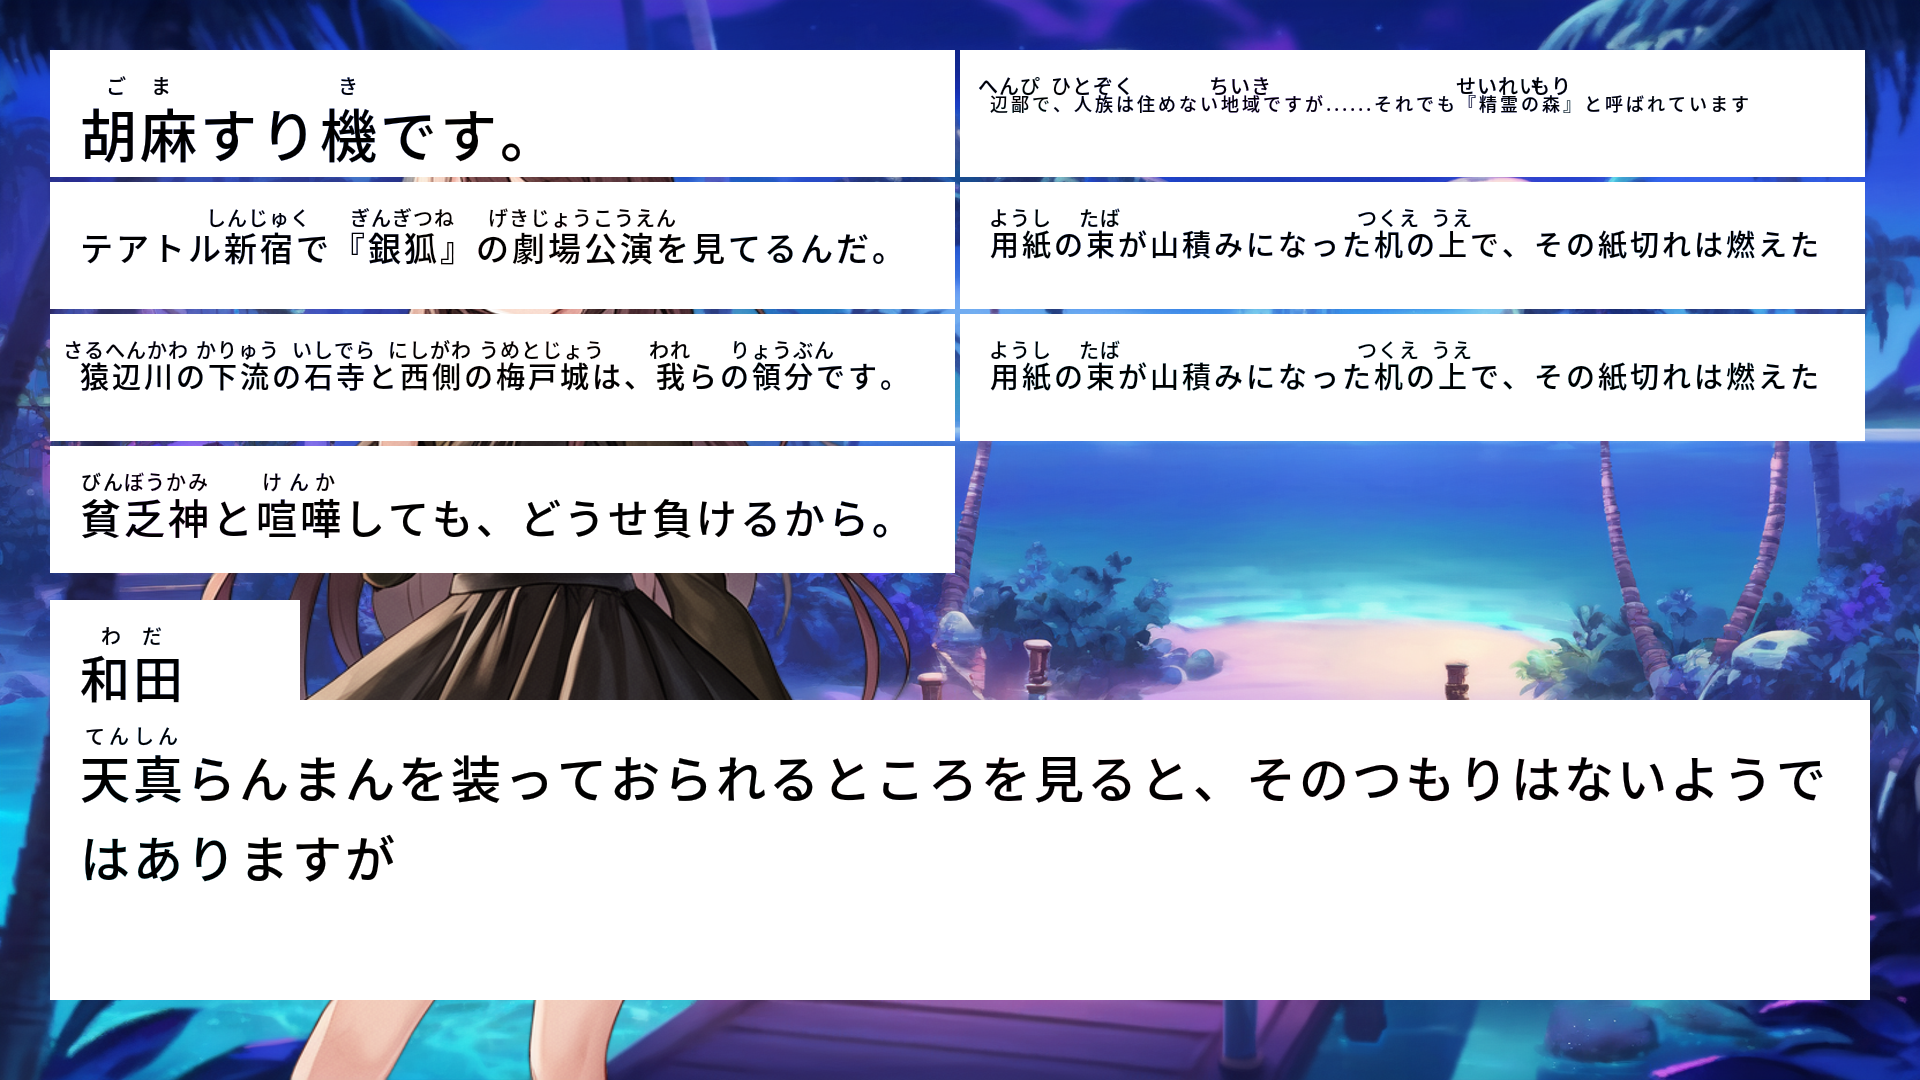

In [5]:
cfg = CFG1()

# 背景画像
cfg.bg_cfg = ImageCFG(path="./sample_images/sample_bg.png")

# キャラクター画像
cfg.character_cfg_list = [
    ImageCFG(path="./sample_images/sample_character.png", tl=Point(200, 0))
    ]

# メッセージ
text = messages.sample(1)["text_ruby_hiragana"].values[0]
cfg.msgbox.text = text
cfg.msgbox.tl = Point(50, 700)
cfg.msgbox.br = Point(1870, 1000)
print(text)

# 名前
name_text = names.sample(1)["text_ruby_hiragana"].values[0]
cfg.namebox.text = name_text
cfg.namebox.tl = Point(50, 600)
cfg.namebox.br = Point(300, 600 + cfg.namebox.minheight)
print(name_text)

# 選択肢
optionbox_list = []
for i in range(7):
    # option_text = split_sentence(messages.sample(1)["text"].values[0])[0]
    option_text = split_sentence(messages.sample(1)["text_ruby_hiragana"].values[0])[0]
    # option_text = split_sentence(messages.iloc[[i]]["text_ruby_hiragana"].values[0])[0]
    option_cfg = TextBoxCFG()
    option_cfg.text = option_text
    option_cfg.change_font_size(25)
    option_cfg.tl = Point(300, 200)
    option_cfg.br = Point(1620, 200 + option_cfg.minheight*5)
    print(option_text)
    optionbox_list.append(option_cfg)
cfg.optionbox_list = get_tiled_option_cfgs(
    nrow=4, ncol=2, tl=Point(x=50, y=50), br=Point(x=1870, y=580), cfgs=optionbox_list,
    margin_h=5, margin_w=5
    )
output = generate_data(cfg)

display(output.image)

In [4]:
output.name_text, output.text, output.option_texts

('ダニー バルク',
 '<ruby>貧乏神<rt>びんぼうかみ</rt></ruby>と<ruby>喧嘩<rt>けんか</rt></ruby>しても、どうせ負けるから。それに<ruby>私<rt>わたくし</rt></ruby>はお<ruby>金<rt>かね</rt></ruby>が大好きだから',
 ['思い付きだけで動くのじゃぞ。',
  '<ruby>胡麻<rt>ごま</rt></ruby>すり<ruby>機<rt>き</rt></ruby>です。',
  '思い付きだけで動くのじゃぞ。',
  '<ruby>天真<rt>てんしん</rt></ruby>らんまんを装っておられるところを見ると、そのつもりはないようではありますが',
  '<ruby>静香<rt>しずか</rt></ruby>さん、さっきまでここにいたみたいだけれど',
  '<ruby>静謐<rt>せいひつ</rt></ruby>の<ruby>魔導具<rt>まどうぐ</rt></ruby>は<ruby>魔法力<rt>まほうりょく</rt></ruby>を通すことで、その<ruby>場<rt>ば</rt></ruby>の<ruby>空気<rt>くうき</rt></ruby>を<ruby>振動<rt>しんどう</rt></ruby>させる',
  '<ruby>胡麻<rt>ごま</rt></ruby>すり<ruby>機<rt>き</rt></ruby>です。'])

In [5]:
# from generation_utils import remove_ruby_tags
# remove_ruby_tags("<ruby>貧乏神<rt>びんぼうかみ</rt></ruby>と<ruby>喧嘩<rt>けんか</rt></ruby>しても、どうせ負けるから。")